The goal of this notebook it to examine a simple momentum continuation bollinger band strategy. Research suggests that in individual stocks upwards BBand breaks often do not mean revert and often signal long momentum. We will use S&P500 data to test if this holds or if mean reversion is present in a stock index. 

- IVV has been used as a proxy for the S&P500. 
- The strategy implemented is long only


In [6]:
#libraries
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import matplotlib.dates as mdates
style.use ('ggplot')
import numpy as np


#import our data and select dates
start = dt.datetime(2000,1,1)
end = dt.datetime(2019,6,6)
df = web.DataReader('IVV','yahoo',start,end)
df.to_csv('IVV.csv')
df = pd.read_csv('IVV.csv', parse_dates = True, index_col=0)

In [7]:
#approx 21 trading days per month used for window
window = 21
upper_std = 2
lower_std = 2
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)
df['MA']=df['Close'].rolling(window=200).mean()
df['Trend']=df['Close']-df['MA']

C:\Users\Seb Usai\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


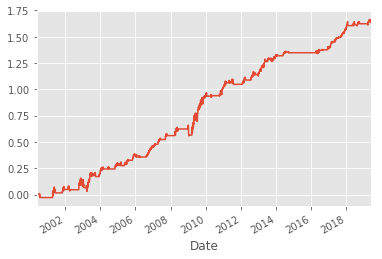

In [8]:
#Create an "empty" column as placeholder for our /position signals
df['Position'] = None
#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
for row in range(len(df)):
    
    if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]):
        df['Position'].iloc[row] = 1
        
    if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
        df['Position'].iloc[row] = 0 
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df['Position'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Strategy Return'] = df['Market Return'] * df['Position']
#Plot the strategy returns
df['Strategy Return'].cumsum().plot()

In [9]:
#drop all rows that have a value below 0 in 'new' to show how we performed above the 200ma

df.drop(df[df.Trend < 0].index, inplace=True)

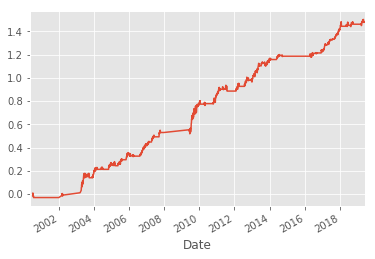

In [10]:
df['Strategy Return'].cumsum().plot()

It can be seen that buying IVV at the break of the Bollinger Bands is strong as expected. Adding a 200ma filter for longer term trend did not add any value in this example.